In [49]:
#load the required modules
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import njit, prange
import warnings
import plotly.graph_objects as go
import plotly.subplots as sp

In [50]:
np.random.seed(50)

In [51]:
@njit(fastmath=True)
def vec_mag(vec):
    """
    This function calculates the magnitude of a 3D vector.

    Parameters:
    vec (np.ndarray): A 3D vector represented as a numpy array.

    Returns:
    float: The magnitude of the vector.
    """
    return np.sqrt(np.sum(vec**2))

In [52]:
@njit(fastmath=True)
def proton_points(R_val):
    """
    This function generates the positions of two protons in 3D space by
    assuming they are aligned along the z-axis.

    Parameters:
    R_val: distance between the protons

    Returns:
    P1, P2: Two points in 3D space representing the positions of the protons.
    """
    P1 = np.array([0, 0, -R_val/2.0])
    P2 = np.array([0, 0, R_val/2.0])
    return P1, P2

In [53]:
@njit(fastmath=True)  
def single_electron_wavefunction(r_e, R_val, alpha, P1, P2, sign=1):
    """
    This function calculates the wavefunction of a
    single electron in the field of two protons.

    Parameters:
    r_e (np.ndarray): The position of the electron in 3D space.
    R_val (float): The distance between the two protons.
    alpha (float): The variational parameter.
    P1 (np.ndarray): The position of the first proton in 3D space.
    P2 (np.ndarray): The position of the second proton in 3D space.
    sign (int): The sign of the wavefunction.

    Returns:
    float: The value of the wavefunction at the given electron position.
    """
    r1 = vec_mag(r_e - P1)
    r2 = vec_mag(r_e - P2)
    #avoid division by zero
    if r1 < 1e-9: r1 = 1e-9
    if r2 < 1e-9: r2 = 1e-9
    term1 = np.exp(-alpha * r1)
    term2 = np.exp(-alpha * r2)
    return term1 + sign * term2

In [54]:
JASTROW_A = 0.5

@njit(fastmath=True)
def calc_Jastrow(r12_mag, beta_val):
    """
    This function Calculates the value of the Jastrow correlation factor.

    Parameters:
    r12_mag (float): The distance between the two electrons.
    beta_val (float): The variational parameter beta.

    Returns:
    float: The value of the Jastrow factor.
    """
    if r12_mag < 1e-9: r12_mag = 1e-9
    return JASTROW_A * r12_mag / (1.0 + beta_val * r12_mag)

In [55]:
@njit(fastmath=True)
def total_wavefunction(r_e1, r_e2, R_val, alpha, beta_val, P1, P2, sign=1):
    """
    This function calculates the total wavefunction of the system.

    Parameters:
    r_e1 (np.ndarray): The position of the first electron in 3D space.
    r_e2 (np.ndarray): The position of the second electron in 3D space.
    R_val (float): The distance between the two protons.
    alpha (float): The variational parameter.
    beta_val (float): The variational parameter for Jastrow factor.
    P1 (np.ndarray): The position of the first proton in 3D space.
    P2 (np.ndarray): The position of the second proton in 3D space.
    sign (int): The sign of the wavefunction.

    Returns:
    float: The value of the total wavefunction at the given electron positions.
    """
    psi_1 = single_electron_wavefunction(r_e1, R_val, alpha, P1, P2, sign=sign)
    psi_2 = single_electron_wavefunction(r_e2, R_val, alpha, P1, P2, sign=sign)

    r12_mag = vec_mag(r_e1 - r_e2)
    if r12_mag < 1e-9:
        r12_mag = 1e-9
        Jastrow_factor = np.exp(calc_Jastrow(r12_mag, beta_val))
    else:
        Jastrow_factor = np.exp(calc_Jastrow(r12_mag, beta_val))

    return psi_1 * psi_2 * Jastrow_factor

In [56]:
@njit(fastmath=True)
def H2_local_energy(r_e1, r_e2, R_val, alpha, beta_val, P1, P2, sign=1):
    """
    This function calculates the local energy of the system.

    Parameters:
    r_e1 (np.ndarray): The position of the first electron in 3D space.
    r_e2 (np.ndarray): The position of the second electron in 3D space.
    R_val (float): The distance between the two protons.
    alpha (float): The variational parameter.
    beta_val (float): The variational parameter for Jastrow factor.
    P1 (np.ndarray): The position of the first proton in 3D space.
    P2 (np.ndarray): The position of the second proton in 3D space.
    sign (int): The sign of the wavefunction.

    Returns:
    float: The local energy of the system at the given electron positions.
    """
    r1p1_mag = vec_mag(r_e1 - P1)
    r1p2_mag = vec_mag(r_e1 - P2)
    r2p1_mag = vec_mag(r_e2 - P1)
    r2p2_mag = vec_mag(r_e2 - P2)
    r12_mag = vec_mag(r_e1 - r_e2)

    #avoid division by zero
    if r1p1_mag < 1e-9: r1p1_mag = 1e-9
    if r1p2_mag < 1e-9: r1p2_mag = 1e-9
    if r2p1_mag < 1e-9: r2p1_mag = 1e-9
    if r2p2_mag < 1e-9: r2p2_mag = 1e-9
    if r12_mag < 1e-9: r12_mag = 1e-9
    if R_val < 1e-9: R_val = 1e-9

    #potential energy terms
    V = -1.0/r1p1_mag - 1.0/r1p2_mag - 1.0/r2p1_mag - 1.0/r2p2_mag \
        + 1.0/r12_mag + 1.0/R_val

    #kinetic energy of electron 1
    step = 1e-4
    KE1 = 0.0
    r1 = r_e1
    r2 = r_e2
    for i in range(r1.shape[0]): # Iterate over x,y,z
        r1_plus = r1.copy()
        r1_plus[i] += step
        psi_plus = total_wavefunction(r1_plus, r2, R_val, alpha, beta_val, P1, P2, sign)

        r1_minus = r1.copy()
        r1_minus[i] -= step
        psi_minus = total_wavefunction(r1_minus, r2, R_val, alpha, beta_val, P1, P2, sign)

        KE1 += (psi_plus + psi_minus - 2.0 * total_wavefunction(r1, r2, R_val, alpha, beta_val, P1, P2, sign))

    KE1 = -0.5 * KE1 / (step**2 * total_wavefunction(r1, r2, R_val, alpha, beta_val, P1, P2, sign))
    #kinetic energy of electron 2
    KE2 = 0.0
    for i in range(r2.shape[0]):
        r2_plus = r2.copy()
        r2_plus[i] += step
        psi_plus = total_wavefunction(r1, r2_plus, R_val, alpha, beta_val, P1, P2, sign)

        r2_minus = r2.copy()
        r2_minus[i] -= step
        psi_minus = total_wavefunction(r1, r2_minus, R_val, alpha, beta_val, P1, P2, sign)

        KE2 += (psi_plus + psi_minus - 2.0 * total_wavefunction(r1, r2, R_val, alpha, beta_val, P1, P2, sign))

    KE2 = -0.5 * KE2 / (step**2 * total_wavefunction(r1, r2, R_val, alpha, beta_val, P1, P2, sign))

    #total energy of the electron-proton system
    E = V + KE1 + KE2

    return E

In [57]:
@njit 
def H2_VMC(r, R_val, Z, step_size, samples=10000, alpha_val=2.0, beta_val=1.0, sign=1):
    """
    This function performs Variational Monte Carlo (VMC) simulation for the H2 molecule.

    Parameters:
        r (np.ndarray):  A 2x3 array containing the initial 3D positions of the two electrons.
        R_val (float): The inter-proton distance (in Bohr radii).
        Z (float): The nuclear charge (1.0 for hydrogen).
        step_size (float): The step size for the Metropolis algorithm.
        samples (int): The number of VMC steps to perform (default: 10000).
        alpha_val (float): The variational parameter alpha (default: 2.0).
        beta_val (float): The variational parameter beta (default: 1.0).
        sign (int): +1 for the bonding orbital, -1 for the anti-bonding orbital (default: 1).
    Returns:
       tuple: A tuple containing:
            - mean_r12 (float): The mean electron-electron distance.
            - energy_saved (list): A list of floats, storing the local energy at each VMC step.
            - acceptance_rate (float): The acceptance rate of the Metropolis algorithm.
    """
    position_saved = []
    energy_saved = []
    P1, P2 = proton_points(R_val)
    r1 = r[0].copy()
    r2 = r[1].copy()
    psi_T_current = total_wavefunction(r1, r2, R_val, alpha_val, beta_val, P1, P2, sign)
    accepted_moves = 0
    sum_r12 = 0.0
    for n in range(samples):
        r1_new = r1 + step_size * (np.random.rand(3) - 0.5)
        r2_new = r2 + step_size * (np.random.rand(3) - 0.5)

        psi_T_new = total_wavefunction(r1_new, r2_new, R_val, alpha_val, beta_val, P1, P2, sign)

        if abs(psi_T_current) < 1e-15:
             if abs(psi_T_new) > 1e-15:
                 acceptance_ratio = 1.0
             else:
                 acceptance_ratio = 0.0
        else:
            acceptance_ratio = (psi_T_new / psi_T_current)**2

        if np.random.rand() < acceptance_ratio:
            r1 = r1_new
            r2 = r2_new
            psi_T_current = psi_T_new
            accepted_moves += 1
        
        position_saved.append(np.stack((r1,r2)).copy())
        energy_saved.append(H2_local_energy(r1, r2, R_val, alpha_val, beta_val, P1, P2, sign))
        r12_mag = vec_mag(r1 - r2)
        sum_r12 += r12_mag
        
    mean_r12 = sum_r12 / samples
    acceptance_rate = accepted_moves / samples
    return mean_r12, energy_saved, acceptance_rate

In [58]:
def alpha_opt(alpha_list, R_val, Z, step, samples=10000, sign=1):
    """
    This function optimizes the alpha variational parameter
    for the H2 molecule using VMC.

    Parameters:
        alpha_list (list): A list of alpha values to test.
        R_val (float): The inter-proton distance.
        Z (float): The nuclear charge.
        step (float): The VMC step size.
        samples (int): The number of VMC steps to perform for each alpha (default: 10000).
        sign (int): +1 for the bonding orbital, -1 for the anti-bonding orbital (default: 1).

    Returns:
        tuple: A tuple containing:
            - saved_energies (list): A list of the mean energies for each alpha value.
            - optimal_alpha (float): The alpha value that minimizes the energy.
            - variance (list): A list of the energy variances for each alpha value.
            - mean_energies (list): A list of the mean energies for each alpha value (same as saved_energies).
    """
    mean_energies = []
    for a in alpha_list:
        r = np.random.rand(2, 3)
        _, energies, _ = H2_VMC(r, R_val, Z, step, samples, a, 1, sign=sign)
        mean_e = np.mean(energies)
        mean_energies.append(mean_e)

    optimal_alpha = alpha_list[np.argmin(mean_energies)]
    return optimal_alpha, mean_energies

In [59]:
def beta_opt(beta_list, optimal_alpha, R_val, Z, step, samples=10000, sign=1):
    """
    This function optimizes the beta variational parameter
    for the H2 molecule using VMC.

    Parameters:
        beta_list (list): A list of beta values to test.
        optimal_alpha (float): The optimized alpha value to use.
        R_val (float): The inter-proton distance.
        Z (float): The nuclear charge.
        step (float): The VMC step size.
        samples (int): The number of VMC steps to perform for each beta (default: 10000).
        sign (int): +1 for the bonding orbital, -1 for the anti-bonding orbital (default: 1).

    Returns:
        tuple: A tuple containing:
            - saved_energies (list): A list of the mean energies for each beta value.
            - optimal_beta (float): The beta value that minimizes the energy.
            - variance (list): A list of the energy variances for each beta value.
            - mean_energies (list): A list of the mean energies for each beta value (same as saved_energies).
    """
    mean_energies = []
    for b in beta_list:
        r = np.random.rand(2, 3)
        _, energies, _ = H2_VMC(r, R_val, Z, step, samples, optimal_alpha, b, sign=sign)
        mean_e = np.mean(energies)
        mean_energies.append(mean_e)
    
    optimal_beta = beta_list[np.argmin(mean_energies)]
    return optimal_beta, mean_energies

In [60]:
R_val = 1.4
Z = 1.0
N_STEPS = 200000
INITIAL_STEP_SIZE = 0.5

alpha_list = np.linspace(0.5, 2.0, 10)
optimal_alpha, energies_alpha = alpha_opt(alpha_list, R_val, Z, INITIAL_STEP_SIZE, N_STEPS)
print(f"Optimal alpha: {optimal_alpha}")

beta_list = np.linspace(0.1, 2.0, 10)
optimal_beta, energies_beta = beta_opt(beta_list, optimal_alpha, R_val, Z, INITIAL_STEP_SIZE, N_STEPS)
energies_beta = np.where(np.isnan(energies_beta), np.inf, energies_beta)
optimal_beta = beta_list[np.argmin(energies_beta)]
print(f"Optimal beta: {optimal_beta}")

Optimal alpha: 1.1666666666666665
Optimal beta: 0.7333333333333333


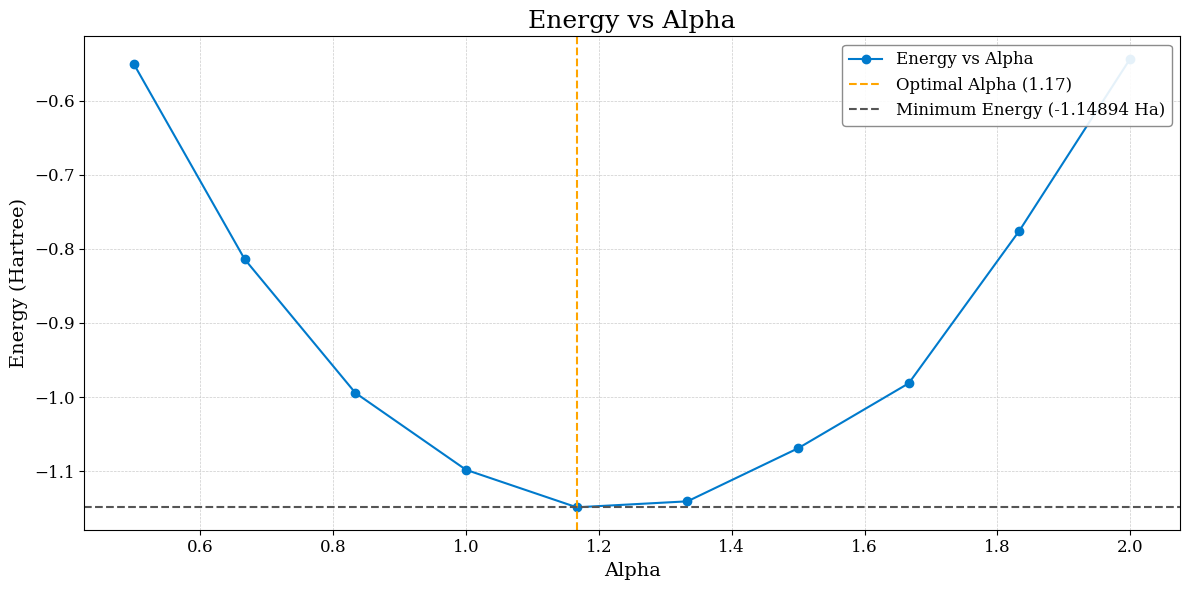

Optimal alpha: 1.17
Minimum energy: -1.14894 Ha


In [61]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'grid.color': '#cccccc',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.figsize': [12, 6],
    'legend.fontsize': 12,
    'font.family': 'serif',
})

min_energy = np.min(energies_alpha)

plt.figure(facecolor='white')
plt.plot(alpha_list, energies_alpha, '-o', color='#007acc', label='Energy vs Alpha', markersize=6)
plt.axvline(optimal_alpha, color='#ffa500', linestyle='--', linewidth=1.5, label=f'Optimal Alpha ({optimal_alpha:.2f})')
plt.axhline(min_energy, color='#555555', linestyle='--', linewidth=1.5, label=f'Minimum Energy ({min_energy:.5f} Ha)')

plt.title("Energy vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Energy (Hartree)")
plt.grid(True)
plt.legend(loc='upper right', facecolor='white', edgecolor='gray', framealpha=0.9)
plt.tight_layout()
plt.show()

print(f"Optimal alpha: {optimal_alpha:.2f}")
print(f"Minimum energy: {min_energy:.5f} Ha")


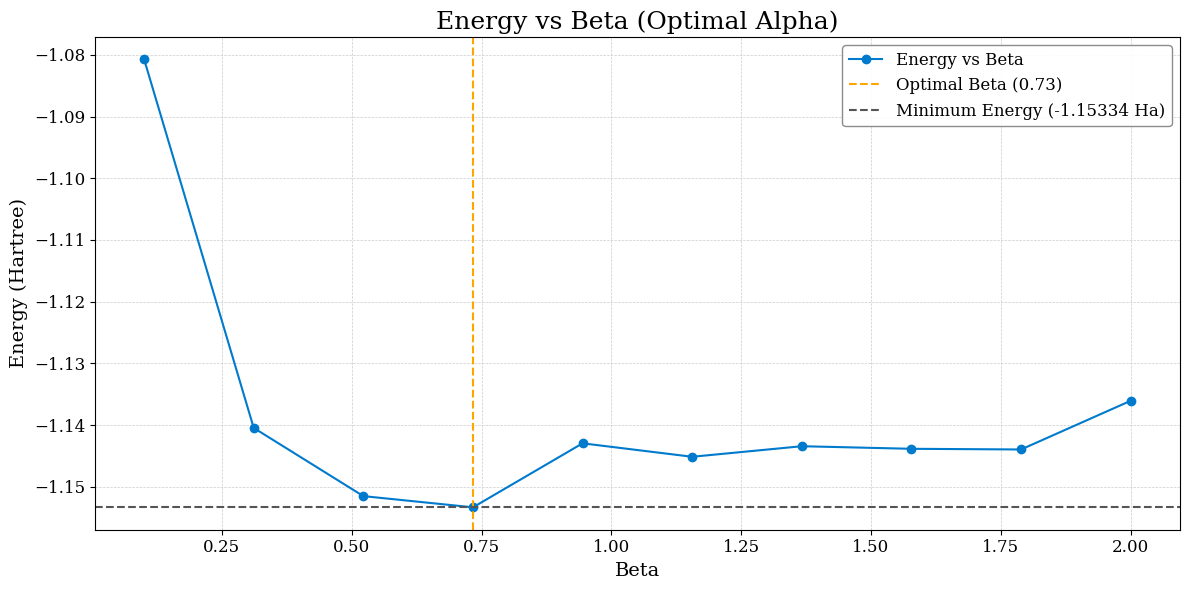

Optimal beta: 0.73
Minimum energy (beta): -1.15334 Ha


In [62]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Matplotlib settings
mpl.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'grid.color': '#cccccc',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.figsize': [12, 6],
    'legend.fontsize': 12,
    'font.family': 'serif',
})

min_energy_beta = np.min(energies_beta)

plt.figure(facecolor='white')
plt.plot(beta_list, energies_beta, '-o', color='#007acc', label='Energy vs Beta', markersize=6)
plt.axvline(optimal_beta, color='#ffa500', linestyle='--', linewidth=1.5, label=f'Optimal Beta ({optimal_beta:.2f})')
plt.axhline(min_energy_beta, color='#555555', linestyle='--', linewidth=1.5, label=f'Minimum Energy ({min_energy_beta:.5f} Ha)')

plt.title("Energy vs Beta (Optimal Alpha)")
plt.xlabel("Beta")
plt.ylabel("Energy (Hartree)")
plt.grid(True)
plt.legend(loc='upper right', facecolor='white', edgecolor='gray', framealpha=0.9)
plt.tight_layout()
plt.show()

print(f"Optimal beta: {optimal_beta:.2f}")
print(f"Minimum energy (beta): {min_energy_beta:.5f} Ha")


In [63]:
R_values = np.linspace(0.5, 3.0, 20)
N_STEPS = 200000
INITIAL_STEP_SIZE = 0.5
Z = 1.0
alpha_val = optimal_alpha
beta_val = optimal_beta

results_bonding = []

print("Starting VMC for bonding (+) wavefunction...")
for R_val in R_values:
    r = np.random.rand(2, 3)
    _, energies, _ = H2_VMC(r, R_val, Z, INITIAL_STEP_SIZE, N_STEPS, alpha_val, beta_val, sign=1)

    mean_e = np.mean(energies)
    results_bonding.append({'R': R_val, 'E': mean_e, 'alpha': alpha_val, 'beta': beta_val})

results_bonding_arr = np.array([(r['R'], r['E']) for r in results_bonding])

Starting VMC for bonding (+) wavefunction...


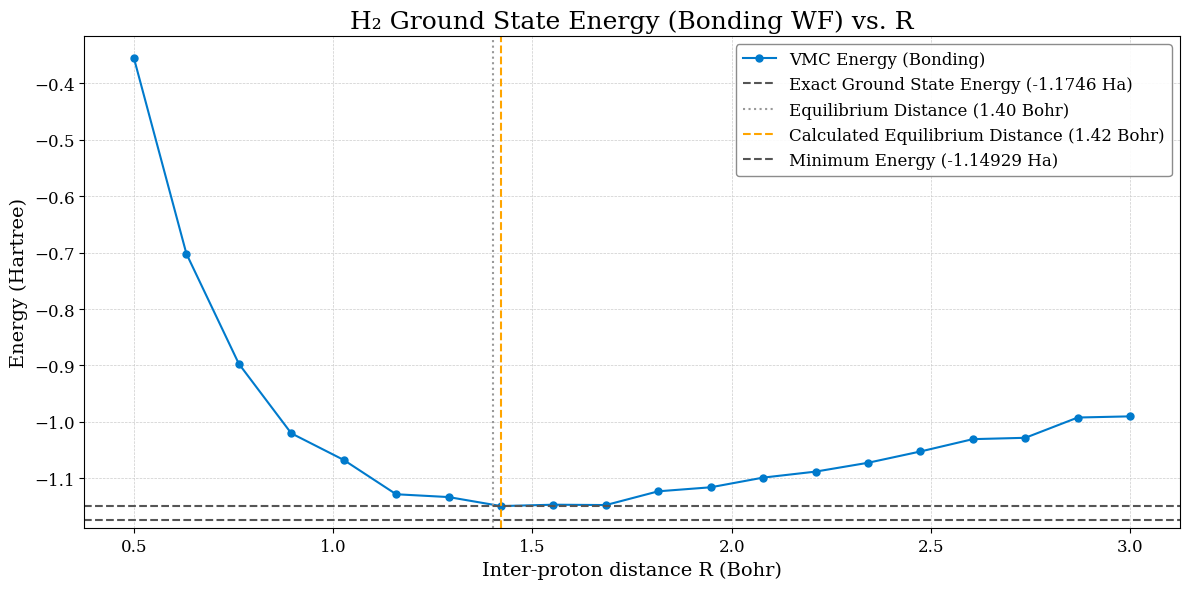

Calculated Equilibrium Distance: 1.42 Bohr
Minimum Energy: -1.14929 Ha


In [64]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'grid.color': '#cccccc',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.figsize': [12, 6],
    'legend.fontsize': 12,
    'font.family': 'serif',
})

min_energy_idx = np.argmin(results_bonding_arr[:, 1])
min_energy_R = results_bonding_arr[min_energy_idx, 0]
min_energy = results_bonding_arr[min_energy_idx, 1]

plt.figure(facecolor='white')
plt.plot(results_bonding_arr[:, 0], results_bonding_arr[:, 1], '-o', color='#007acc', markersize=5, label='VMC Energy (Bonding)')

plt.axhline(-1.17460, color='#555555', linestyle='--', linewidth=1.5, label='Exact Ground State Energy (-1.1746 Ha)')
plt.axvline(1.40, color='#999999', linestyle=':', linewidth=1.5, label='Equilibrium Distance (1.40 Bohr)')
plt.axvline(min_energy_R, color='#ffa500', linestyle='--', linewidth=1.5, label=f'Calculated Equilibrium Distance ({min_energy_R:.2f} Bohr)')
plt.axhline(min_energy, color='#555555', linestyle='--', linewidth=1.5, label=f'Minimum Energy ({min_energy:.5f} Ha)')

plt.title("H₂ Ground State Energy (Bonding WF) vs. R")
plt.xlabel("Inter-proton distance R (Bohr)")
plt.ylabel("Energy (Hartree)")
plt.grid(True)

plt.legend(loc='upper right', facecolor='white', edgecolor='gray', framealpha=0.9)
plt.tight_layout()
plt.show()

print(f"Calculated Equilibrium Distance: {min_energy_R:.2f} Bohr")
print(f"Minimum Energy: {min_energy:.5f} Ha")


In [65]:
print("Starting VMC for anti-bonding (-) wavefunction...")
results_anti_bonding = []
for R_val in R_values:
    r = np.random.rand(2, 3)
    _, energies, _ = H2_VMC(r, R_val, Z, INITIAL_STEP_SIZE, N_STEPS, alpha_val, beta_val, sign=-1)

    mean_e = np.mean(energies)
    results_anti_bonding.append({'R': R_val, 'E': mean_e, 'alpha': alpha_val, 'beta': beta_val})

results_anti_bonding_arr = np.array([(r['R'], r['E']) for r in results_anti_bonding])

Starting VMC for anti-bonding (-) wavefunction...


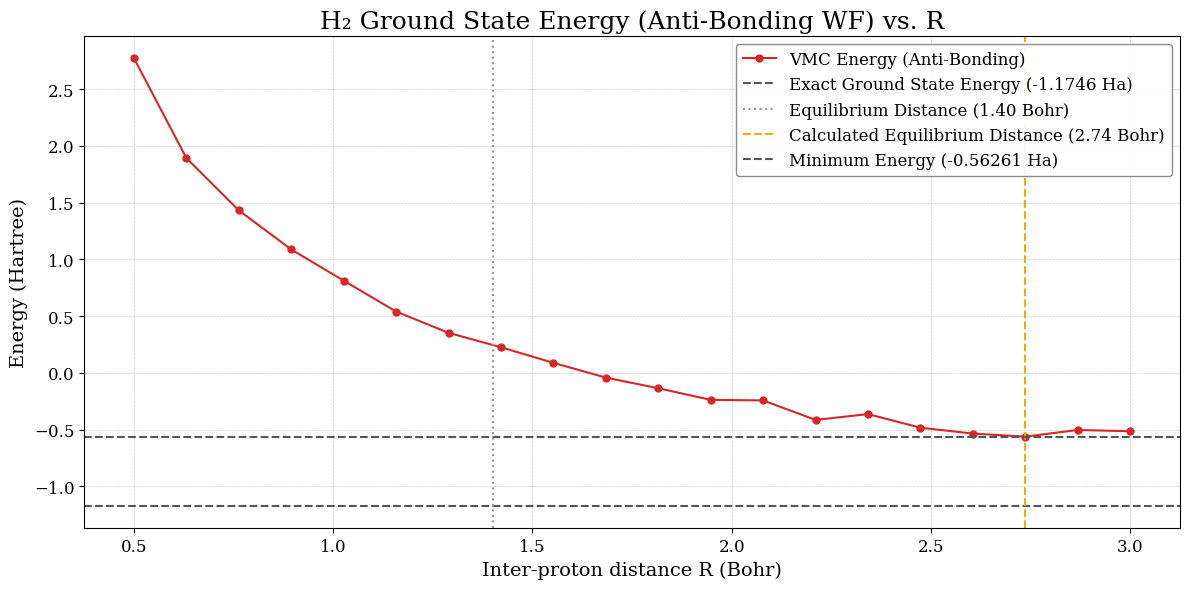

Calculated Equilibrium Distance: 2.74 Bohr
Minimum Energy: -0.56261 Ha


In [66]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'grid.color': '#cccccc',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.figsize': [12, 6],
    'legend.fontsize': 12,
    'font.family': 'serif',
})

min_energy_idx = np.argmin(results_anti_bonding_arr[:, 1])
min_energy_R = results_anti_bonding_arr[min_energy_idx, 0]
min_energy = results_anti_bonding_arr[min_energy_idx, 1]

plt.figure(facecolor='white')
plt.plot(results_anti_bonding_arr[:, 0], results_anti_bonding_arr[:, 1], '-o', color='#d62728', markersize=5, label='VMC Energy (Anti-Bonding)')

plt.axhline(-1.17460, color='#555555', linestyle='--', linewidth=1.5, label='Exact Ground State Energy (-1.1746 Ha)')
plt.axvline(1.40, color='#999999', linestyle=':', linewidth=1.5, label='Equilibrium Distance (1.40 Bohr)')
plt.axvline(min_energy_R, color='#ffa500', linestyle='--', linewidth=1.5, label=f'Calculated Equilibrium Distance ({min_energy_R:.2f} Bohr)')
plt.axhline(min_energy, color='#555555', linestyle='--', linewidth=1.5, label=f'Minimum Energy ({min_energy:.5f} Ha)')

plt.title("H₂ Ground State Energy (Anti-Bonding WF) vs. R")
plt.xlabel("Inter-proton distance R (Bohr)")
plt.ylabel("Energy (Hartree)")
plt.grid(True)

plt.legend(loc='upper right', facecolor='white', edgecolor='gray', framealpha=0.9)
plt.tight_layout()
plt.show()

print(f"Calculated Equilibrium Distance: {min_energy_R:.2f} Bohr")
print(f"Minimum Energy: {min_energy:.5f} Ha")


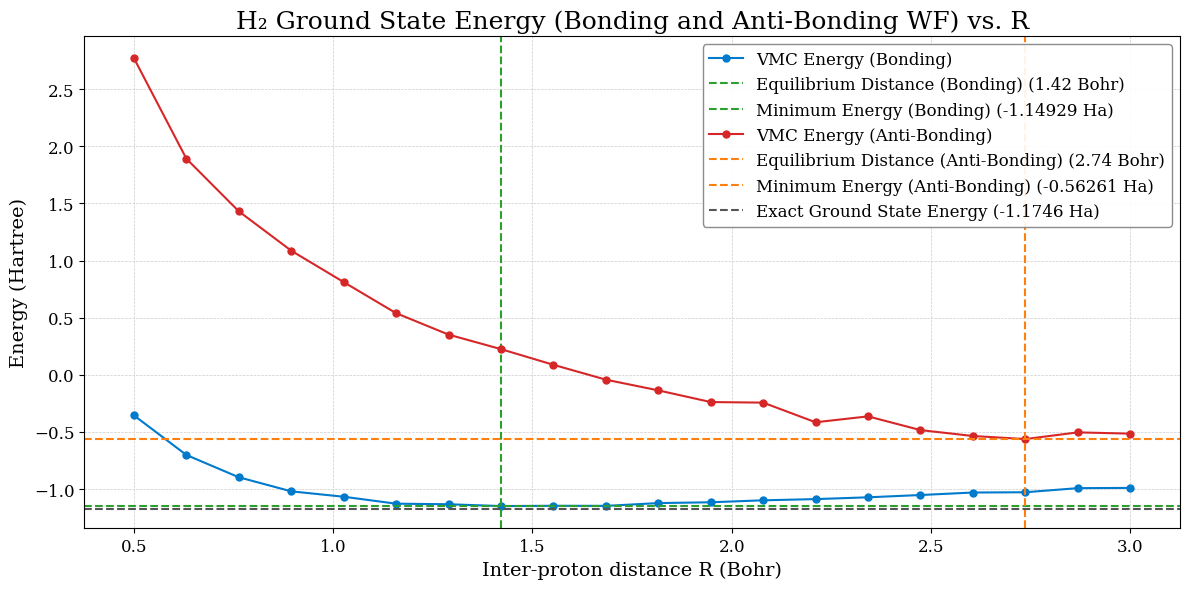

Bonding - Equilibrium Distance: 1.42 Bohr, Minimum Energy: -1.14929 Ha
Anti-Bonding - Equilibrium Distance: 2.74 Bohr, Minimum Energy: -0.56261 Ha


In [67]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'grid.color': '#cccccc',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.figsize': [12, 6],
    'legend.fontsize': 12,
    'font.family': 'serif',
})

min_bonding_idx = np.argmin(results_bonding_arr[:, 1])
min_bonding_R = results_bonding_arr[min_bonding_idx, 0]
min_bonding_energy = results_bonding_arr[min_bonding_idx, 1]

min_anti_bonding_idx = np.argmin(results_anti_bonding_arr[:, 1])
min_anti_bonding_R = results_anti_bonding_arr[min_anti_bonding_idx, 0]
min_anti_bonding_energy = results_anti_bonding_arr[min_anti_bonding_idx, 1]

plt.figure(facecolor='white')

plt.plot(results_bonding_arr[:, 0], results_bonding_arr[:, 1], '-o', color='#007acc', markersize=5, label='VMC Energy (Bonding)')
plt.axvline(min_bonding_R, color='#2ca02c', linestyle='--', linewidth=1.5, label=f'Equilibrium Distance (Bonding) ({min_bonding_R:.2f} Bohr)')
plt.axhline(min_bonding_energy, color='#2ca02c', linestyle='--', linewidth=1.5, label=f'Minimum Energy (Bonding) ({min_bonding_energy:.5f} Ha)')

plt.plot(results_anti_bonding_arr[:, 0], results_anti_bonding_arr[:, 1], '-o', color='#d62728', markersize=5, label='VMC Energy (Anti-Bonding)')
plt.axvline(min_anti_bonding_R, color='#ff7f0e', linestyle='--', linewidth=1.5, label=f'Equilibrium Distance (Anti-Bonding) ({min_anti_bonding_R:.2f} Bohr)')
plt.axhline(min_anti_bonding_energy, color='#ff7f0e', linestyle='--', linewidth=1.5, label=f'Minimum Energy (Anti-Bonding) ({min_anti_bonding_energy:.5f} Ha)')

plt.axhline(-1.17460, color='#555555', linestyle='--', linewidth=1.5, label='Exact Ground State Energy (-1.1746 Ha)')

plt.title("H₂ Ground State Energy (Bonding and Anti-Bonding WF) vs. R")
plt.xlabel("Inter-proton distance R (Bohr)")
plt.ylabel("Energy (Hartree)")
plt.grid(True)

plt.legend(loc='upper right', facecolor='white', edgecolor='gray', framealpha=0.9)
plt.tight_layout()
plt.show()

print(f"Bonding - Equilibrium Distance: {min_bonding_R:.2f} Bohr, Minimum Energy: {min_bonding_energy:.5f} Ha")
print(f"Anti-Bonding - Equilibrium Distance: {min_anti_bonding_R:.2f} Bohr, Minimum Energy: {min_anti_bonding_energy:.5f} Ha")


In [68]:
R_values = np.linspace(0.5, 3.0, 20)
mean_r12_values = []

print("Starting VMC calculation for different R values...")
for R_val in R_values:
    r = np.random.rand(2, 3)
    mean_r12, acceptance_rate, energies = H2_VMC(r, R_val, Z, INITIAL_STEP_SIZE, N_STEPS, alpha_val=optimal_alpha, beta_val=0.9, sign=1)
    mean_r12_values.append(mean_r12)
print(np.array(mean_r12_values))

Starting VMC calculation for different R values...
[2.02856549 2.08479104 2.0350719  2.01325034 2.07442033 2.16458469
 2.23236669 2.2387284  2.2593369  2.24993046 2.30663425 2.30758534
 2.40192188 2.47868496 2.49764072 2.65646551 2.60035004 2.70221867
 2.63679933 2.74276492]


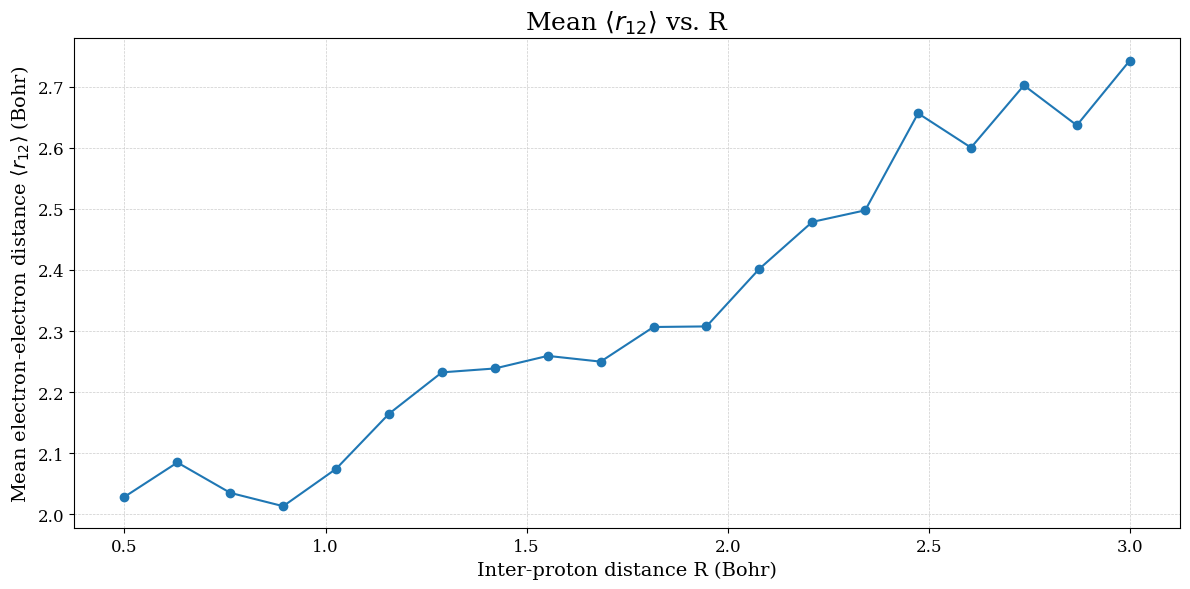

In [69]:
fig, ax = plt.subplots()
ax.plot(R_values, mean_r12_values, marker='o', linestyle='-')
ax.set_xlabel("Inter-proton distance R (Bohr)")
ax.set_ylabel(r"Mean electron-electron distance $\langle r_{12} \rangle$ (Bohr)")
ax.set_title(r"Mean $\langle r_{12} \rangle$ vs. R")
ax.grid(True)
plt.tight_layout()

plt.show()